가게를 운영함에 있어서 가장 중요한 평가 요소는 결국 매출일 것입니다.  
하지만 영세한 가게들의 경우 데이터를 활용해 매출을 예측하기는 어렵습니다.  
매출과 매입의 총액 정도의 정보만을 찾을 수는 있지만 이를 예측하기 위한 세부적 정보들을 찾아 활용하기까지는 어렵습니다.  
미국의 대형마트인 월마트에서는 어떠한 정보를 이용해서 매출을 예측하는지를 살펴보고 이를 통해서 적용할 수 있을 법한 내용들이나 참고할 부분들을 찾아보고자 합니다.  

In [3]:
# from google.colab import files
# files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"winocas","key":"d0f593e1caca70735e117d0f7cec5748"}'}

In [4]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/kaggle.json
# !chmod 600 ~/.kaggle/kaggle.json #permission warning 방지

In [5]:
# ! kaggle datasets download -d iamprateek/wallmart-sales-forecast-datasets

  0% 0.00/3.36M [00:00<?, ?B/s]
100% 3.36M/3.36M [00:00<00:00, 55.5MB/s]


In [6]:
!unzip \*.zip  && rm *.zip # 압축해제

Archive:  wallmart-sales-forecast-datasets.zip
  inflating: features.csv            
  inflating: stores.csv              
  inflating: test.csv                
  inflating: train.csv               


# EDA

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [8]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
stores = pd.read_csv('stores.csv')
feat = pd.read_csv('features.csv')

In [9]:
train

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False


In [13]:
test

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False
...,...,...,...,...
115059,45,98,2013-06-28,False
115060,45,98,2013-07-05,False
115061,45,98,2013-07-12,False
115062,45,98,2013-07-19,False


In [14]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [15]:
feat

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False


## 변수 확인

* train set/test set의 변수들   
\- **Store : the store number(45개의 월마트 매장)**  
\- Dept : the department number(각 매장의 판매 부서(코너)별 매출)  
\- Date : the week  
\- Weekly_Sales :  sales for the given department in the given store / target으로 train에만 있습니다.  
\- IsHoliday : whether the week is a special holiday week(실제로 명절이나 주말과 공휴일이 포함된 연휴 기간에는 매출이 올라가게 됩니다.)  

* features의 변수들  
\- **Store : the store number(45개의 월마트 매장)**  
\- Date : the week  
\- Temperature : average temperature in the region(날씨와도 연관이 될 것 같습니다.)  
\- Fuel_Price : cost of fuel in the region(경제적 상황과 연관이 있을 것 같습니다.)  
\- MarkDown1-5 : anonymized data related to promotional markdowns that Walmart is running.   
MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.  
\- CPI : the consumer price index  
\- Unemployment : the unemployment rate  
\- IsHoliday : whether the week is a special holiday week  

* stores의 변수들  
\- **Store : the store number(45개의 월마트 매장)**  
\- Type : 가게의 종류 정도로 생각하면 될 것 같습니다.  
\- Size : 가게의 크기로 생각됩니다.


주어진 4가지의 데이터를 살펴보면 test에 주어진 날짜들의 store별 department 별 매출을 예측하기 위해서 기존의 train set에 추가적인 정보들을 제고하는 features와 stores의 자료들을 사용해야함을 알 수 있습니다.   
주어진 데이터들로부터 store별 department별 주간 매출액을 예측하기 위해서 사용할 수 있도록 주어진 변수들을 살펴보면 다음과 같습니다.  

Store : 월마트 매장의 번호(주어진 모든 데이터에 공통으로 들어있음, 이를 기준으로 join)  
Dept : 월마트 내 판매코너의 번호  
IsHoliday : 매출이 잡힌 주가 공휴일이 있는 주인지 여부  
모든 공휴일이 아니라 다음과 같은 공휴일만을 고려한 데이터입니다.  
>Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13  
Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13  
Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13  
Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13  

Temperature : 해당 매장의 지역의 평균 기온  
MarkDown1\~5 : 판촉할인 정보  
>  Nov 2011부터 데이터 잡히고 모든 매장에서 시행된 것은 아니라 사용하기 어려워 보입니다.    

Fuel_Price : 유가, 사회 전반적 지표, 유가 상승 -> 소비 위축 / 제품 가격 상승  
CPI : 소비자물가지수 /  가정이 소비하기 위해 구입하는 재화와 용역의 평균 가격을 측정한 지수  
Unemployment : 실업률  
Type : 매장 종류  
Size : 매장 크기   
이들 중 Fuel_Price와 CPI는 경기 전반에 관한 내용으로 생각할 수 있습니다.    




In [24]:
train.dtypes

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
dtype: object

In [25]:
test.dtypes

Store         int64
Dept          int64
Date         object
IsHoliday      bool
dtype: object

In [26]:
stores.dtypes

Store     int64
Type     object
Size      int64
dtype: object

In [27]:
feat.dtypes

Store             int64
Date             object
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
IsHoliday          bool
dtype: object

변수들의 타입을 확인해보면 트리기반 회귀모형을 사용할 것이므로 다른 변수들은 두고 Date 변수가 object로 잡혀있어 이를 연도와 월로 처리할 필요성이 있어보입니다.

### target 변수 확인

In [47]:
target = 'Weekly_Sales'

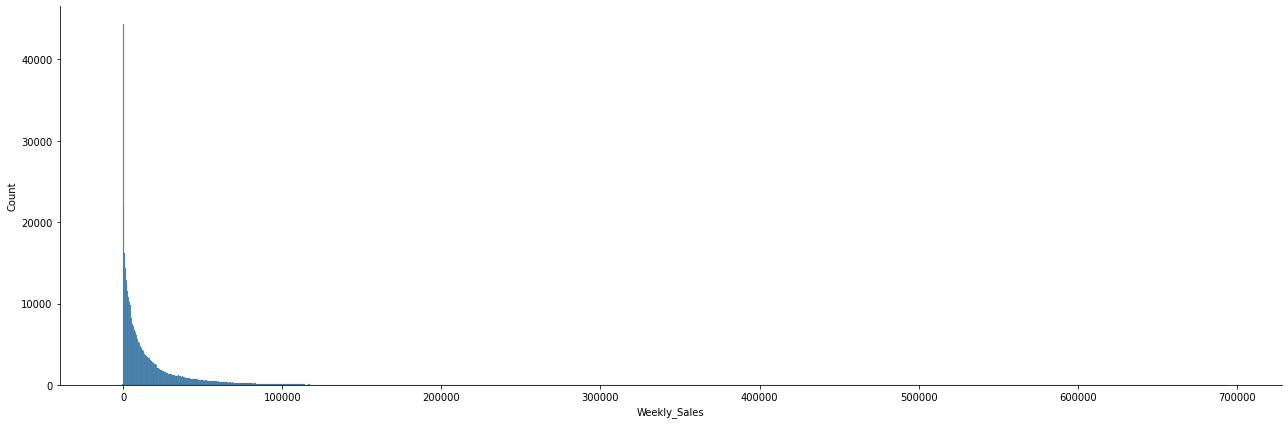

In [48]:
sns.displot(train[target], height=6, aspect=3);

In [49]:
train[target].max()

693099.36

In [50]:
train[target].min()

-4988.94

Weekly_Sales의 분포가 불균형적임을 확인했습니다.  
이를 해소하기 위해서 log 변환 등을 사용해보겠습니다.  
또한 현재 음수인 값이 있어 0보다 큰 값만을 추려 사용해야함을 확인했습니다.  

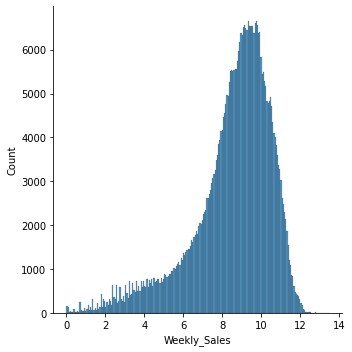

In [51]:
sns.displot(np.log1p( train[train[target] >0][target] ));

기존의 Weekly_Sales값들 중 0보다 큰 값에 대해 로그변환을 사용해보니  
기존의 데이터보다 치우침이 많이 완화되었음을 확인할 수 있습니다.  

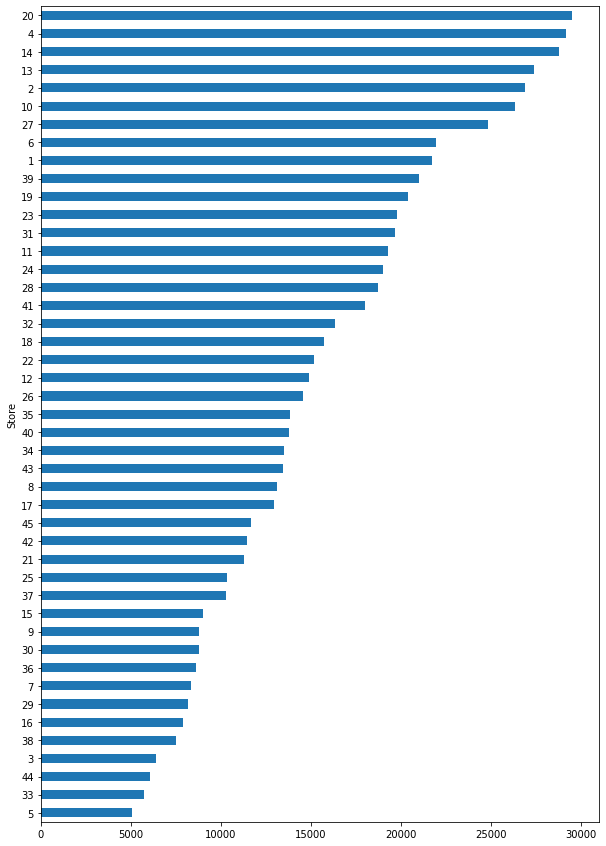

In [59]:
plt.figure(figsize=(10,15))
train.groupby(['Store'])[target].mean().sort_values().plot.barh();

매장별 평균 주간 매출액을 비교해보니 매장별로 매출의 차이가 현저하게 남을 알 수 있습니다.  
이를 통해서 주간 매출액의 예측할 때 **어떤 매장인지**도 중요한 요소로 작용할 수 있을 것 같습니다. 

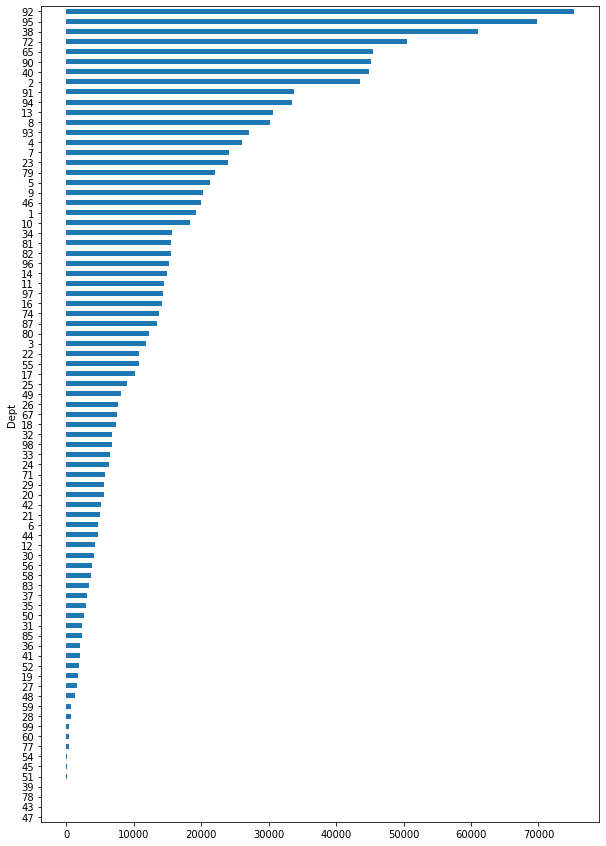

In [61]:
plt.figure(figsize=(10,15))
train.groupby(['Dept'])[target].mean().sort_values().plot.barh();

판매 부서(코너)별로도 평균 주간 매출액의 차이가 현저하기 나타남을 알 수 있었습니다.  
이를 좀 더 해석해보면 해당 판매 코너에서 판매하는 품목에 따라 주간 매출액이 달라짐을 확인할 수 있습니다. 

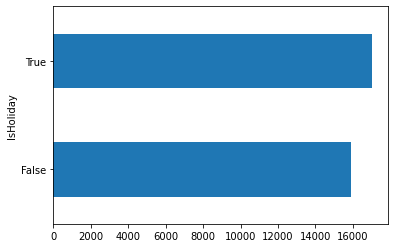

In [60]:
train.groupby(['IsHoliday'])[target].mean().sort_values().plot.barh();

해당 주에 공휴일이 있는지 여부에 따른 주간 매출의 차이를 살펴보니 차이가 있긴 하지만 유의미한 차이가 있을지는 확인해봐야할 것 같습니다. 

나머지 feature들과 target과의 관계는 데이터를 병합하고 전처리를 통해 새로운 변수를 만들어내면서 확인해보도록 하겠습니다. 

## 결측치 확인

In [16]:
[(x, train[x].isnull().sum()) for x in train.columns if train[x].isnull().any()]

[]

In [17]:
[(x, test[x].isnull().sum()) for x in test.columns if test[x].isnull().any()]

[]

In [18]:
[(x, stores[x].isnull().sum()) for x in stores.columns if stores[x].isnull().any()]

[]

In [19]:
[(x, feat[x].isnull().sum()) for x in feat.columns if feat[x].isnull().any()]

[('MarkDown1', 4158),
 ('MarkDown2', 5269),
 ('MarkDown3', 4577),
 ('MarkDown4', 4726),
 ('MarkDown5', 4140),
 ('CPI', 585),
 ('Unemployment', 585)]

In [20]:
feat.shape

(8190, 12)

다른 데이터들은 결측치가 현재 존재하지 않지만 features 데이터에 12개의 변수들 중 7개의 변수에 결측치가 존재함을 확인할 수 있습니다.   
특히 MarkDown 변수들은 데이터의 절반 가까이가 결측치임을 확인할 수 있습니다. 
이는 총 데이터의 기간인 2010-02-05 \~ 2013-07-26 중   
2011년 11월부터 데이터가 잡혔으며 이러한 이유로 2011년 11월 이전과 이후의 데이터들 중 판촉할인의 영향력을 구분지어 사용하기 어려워보여 MarkDown 변수들을 사용하지 못할 것 같습니다.  

In [21]:
feat

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False


MarkDown 변수들은 삭제할 것이므로 남은 결측치가 포함된 변수들은 CPI(소비자물가지수)와 Unemployment(실업률)로 이들은 수치형 변수이므로 평균값을 이용해 대치하면 좋을 것 같습니다. 

## 데이터 병합 및 전처리

\* 생각해 본 전처리  
\- train set과 test set에 각각 stores와 features를 left join해 데이터셋을 새로 구성  
\- features의 markdown1 ~ markdown5 제거 (결측치도 많고 데이터가 총 기간의 중간부터 수집되어 사용하기 어려워보임)  
\- yyyy-mm-dd 형태의 date 변수를 year와 month만 따로 추출  
\- 트리 기반 모델을 사용할 예정이므로  object   타입으로 남은 'Type'변수만 더미변수화  
\- 평균값을 이용한 결측치 대치 ~ pipeline을 이용해 사용

In [62]:
def prepro_train(x) :
    X = x.copy()
    X = X[X['Weekly_Sales'] >0] # target값 >0 인 것들만 사용
    X = X.merge(feat,  how = 'left').merge(stores,  how = 'left') # 추가로 주어진 데이터들 병합해 사용

    X['Year'] = pd.to_datetime(X['Date']).dt.year # Date 중 연도만 따로 추출
    X['Month'] = pd.to_datetime(X['Date']).dt.month # Date 중 월만 따로 추출

    X.drop(columns=['Date', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], inplace = True) # 사용하지 않을 변수 삭제

    X = pd.get_dummies(X, columns = ['Type']) # object 변수형 가진 'Type'을 더미변수화
    return X

In [63]:
prepro_train(train)

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Size,Year,Month,Type_A,Type_B,Type_C
0,1,1,24924.50,False,42.31,2.572,211.096358,8.106,151315,2010,2,1,0,0
1,1,1,46039.49,True,38.51,2.548,211.242170,8.106,151315,2010,2,1,0,0
2,1,1,41595.55,False,39.93,2.514,211.289143,8.106,151315,2010,2,1,0,0
3,1,1,19403.54,False,46.63,2.561,211.319643,8.106,151315,2010,2,1,0,0
4,1,1,21827.90,False,46.50,2.625,211.350143,8.106,151315,2010,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420207,45,98,508.37,False,64.88,3.997,192.013558,8.684,118221,2012,9,0,1,0
420208,45,98,628.10,False,64.89,3.985,192.170412,8.667,118221,2012,10,0,1,0
420209,45,98,1061.02,False,54.47,4.000,192.327265,8.667,118221,2012,10,0,1,0
420210,45,98,760.01,False,56.47,3.969,192.330854,8.667,118221,2012,10,0,1,0


In [64]:
def prepro_test(x) :
    X = x.copy()

    X = X.merge(feat,  how = 'left').merge(stores,  how = 'left')    # 추가로 주어진 데이터들 병합해 사용

    X['Year'] = pd.to_datetime(X['Date']).dt.year # Date 중 연도만 따로 추출
    X['Month'] = pd.to_datetime(X['Date']).dt.month # Date 중 월만 따로 추출

    X.drop(columns=['Date', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], inplace = True) # 사용하지 않을 변수 삭제

    X = pd.get_dummies(X, columns = ['Type'])# object 변수형 가진 'Type'을 더미변수화
    return X

In [65]:
prepro_test(test)

,Store,Dept,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Size,Year,Month,Type_A,Type_B,Type_C
0,1,1,False,55.32,3.386,223.462779,6.573,151315,2012,11,1,0,0
1,1,1,False,61.24,3.314,223.481307,6.573,151315,2012,11,1,0,0
2,1,1,False,52.92,3.252,223.512911,6.573,151315,2012,11,1,0,0
3,1,1,True,56.23,3.211,223.561947,6.573,151315,2012,11,1,0,0
4,1,1,False,52.34,3.207,223.610984,6.573,151315,2012,11,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115059,45,98,False,76.05,3.639,NaN,NaN,118221,2013,6,0,1,0
115060,45,98,False,77.50,3.614,NaN,NaN,118221,2013,7,0,1,0
115061,45,98,False,79.37,3.614,NaN,NaN,118221,2013,7,0,1,0
115062,45,98,False,82.84,3.737,NaN,NaN,118221,2013,7,0,1,0


In [66]:
train1 = prepro_train(train)
test1 = prepro_test(test)

In [70]:
train1.shape, test1.shape

((420212, 14), (115064, 13))

In [68]:
train1.isnull().sum().sum()

0

In [69]:
test1.isnull().sum().sum()

76324

전처리의 결과 test set에서만 결측치가 존재함을 확인했습니다. 

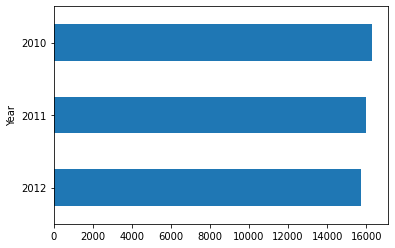

In [74]:
train1.groupby(['Year'])[target].mean().sort_values().plot.barh();

연도별로는 평균 주간 판매액의 큰 차이가 없을 것 같습니다.

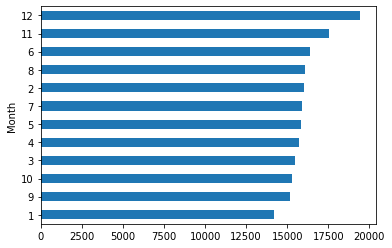

In [73]:
train1.groupby(['Month'])[target].mean().sort_values().plot.barh();

월별로 평균 주간 판매액을 살펴보면 월별로 차이가 유의미하게 남을 확인할 수 있습니다. 

In [79]:
train1[train1['Type_A']==1][target].mean()

20148.108161620257

In [80]:
train1[train1['Type_B']==1][target].mean()

12290.549296565909

In [81]:
train1[train1['Type_C']==1][target].mean()

9549.454168236593

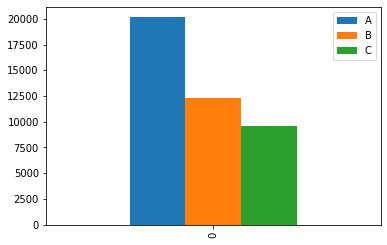

In [85]:
pd.DataFrame({"A" : [train1[train1['Type_A']==1][target].mean()], 
              "B" : [train1[train1['Type_B']==1][target].mean()], 
              "C" : [train1[train1['Type_C']==1][target].mean()]}).plot.bar();

매장의 Type별로도 평균 주간 매출액이 달라짐을 확인할 수 있습니다. 

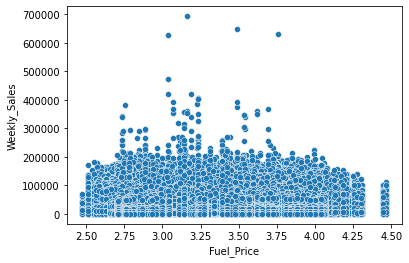

In [88]:
sns.scatterplot(x = 'Fuel_Price', y = 'Weekly_Sales', data = train1);

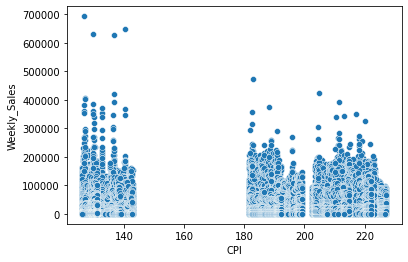

In [90]:
sns.scatterplot(x = 'CPI', y = 'Weekly_Sales', data = train1);

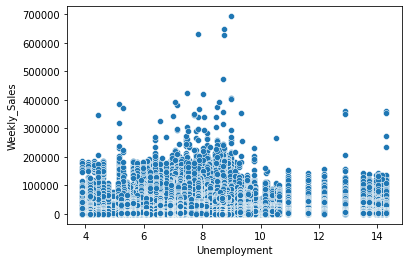

In [91]:
sns.scatterplot(x = 'Unemployment', y = 'Weekly_Sales', data = train1);

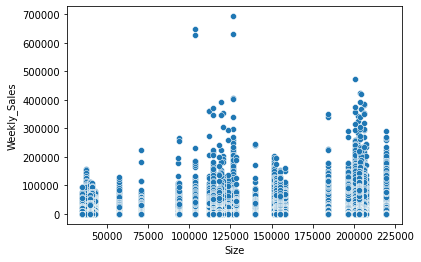

In [92]:
sns.scatterplot(x = 'Size', y = 'Weekly_Sales', data = train1);